In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory

2022-06-09 11:13:45.772531: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print(tf.__version__)

2.5.0


# Loading SIPI Dataset

SIPI dataset was preprocessed using prepare_dataset notebook, so these three folders already contain Detritus/Non-Detritus images.

Training: 70%
Validation: 15%
Testing: 15%

In [3]:
DatasetName = 'Dataset-Detritus-Bubble'

train_dir = DatasetName+'/train'
validation_dir =  DatasetName+'/val'
test_dir = DatasetName+'/test'

test_all_class_dir = 'Dataset-Detritus-Bubble/test'
train_all_class_dir = 'Dataset-Detritus-Bubble/train'
val_all_class_dir = 'Dataset-Detritus-Bubble/val'

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

The three datasets are loaded using keras preprocessing method *image_dataset_from_directory*. Both the batch size and the image size hyperparameters where tested using different values. 

In [5]:
train_dataset = image_dataset_from_directory(train_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 38391 files belonging to 2 classes.


2022-06-09 11:13:51.357616: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-09 11:13:52.191958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.92GiB deviceMemoryBandwidth: 313.37GiB/s
2022-06-09 11:13:52.192718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:81:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2022-06-09 11:13:52.192771: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-09 11:13:52.197372: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library

In [6]:
validation_dataset = image_dataset_from_directory(validation_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 8226 files belonging to 2 classes.
Found 8227 files belonging to 2 classes.


# Training

In [7]:
# Hyperparamers to be used in all models
base_learning_rate = 0.0005
IMG_SHAPE = IMG_SIZE + (3,)
TRAINING_EPOCHS = 40

In [8]:
def train_model(model, epochs):
    print("Training model, epochs: ", epochs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    training_loss = history.history['loss']
    val_loss = history.history['val_loss']

    loss, accuracy = model.evaluate(test_dataset)
    print('Test accuracy :', accuracy)
    
    return acc, val_acc, training_loss, val_loss

In [9]:
def show_plot(acc, val_acc, loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Data Augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Custom CNN model

In [11]:
def get_model_A(drop_value=0.0, data_aug=False, l2_reg=0.0):
    inputs = tf.keras.Input(shape=(160, 160, 3))
    
    if data_aug:
        dag = data_augmentation(inputs)
        processed_input =  tf.keras.applications.densenet.preprocess_input(dag)
    else:
        processed_input =  tf.keras.applications.densenet.preprocess_input(inputs)
    
    conv = keras.layers.Conv2D(filters=16, activation='relu', kernel_size=3)(processed_input)
    pool = keras.layers.MaxPooling2D(2,2)(conv)

    conv = keras.layers.Conv2D(filters=32, activation='relu', kernel_size=3)(pool)
    pool = keras.layers.MaxPooling2D(2,2)(conv)

    conv = keras.layers.Conv2D(filters=64, activation='relu', kernel_size=3)(pool)
    pool = keras.layers.MaxPooling2D(2,2)(conv)

    conv = keras.layers.Conv2D(filters=64, activation='relu', kernel_size=3)(pool)
    pool = keras.layers.MaxPooling2D(2,2)(conv)

    conv = keras.layers.Conv2D(filters=64, activation='relu', kernel_size=3)(pool)
    pool = keras.layers.MaxPooling2D(2,2)(conv)
    
    gal = keras.layers.Flatten()(pool)
    
    x = keras.layers.Dense(512)(gal)
    
    
    if drop_value > 0:
        x = keras.layers.Dropout(drop_value)(x)
    
    if l2_reg > 0:
        x = keras.layers.Dense(1, kernel_regularizer=regularizers.l2(l2_reg),
                bias_regularizer=regularizers.l2(l2_reg),
                activity_regularizer=regularizers.l2(l2_reg))(x)
    else:
        x = keras.layers.Dense(1)(x)
    return keras.Model(inputs, x)

Training from scratch

Training model, epochs:  40
Epoch 1/40


2022-06-09 11:13:54.894247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-09 11:13:54.917089: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099915000 Hz
2022-06-09 11:13:55.087183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-06-09 11:13:55.544157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8302
2022-06-09 11:13:56.226357: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-09 11:13:56.227270: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1200/1200 [==============================] - 31s 24ms/step - loss: 0.3290 - accuracy: 0.8478 - val_loss: 0.2753 - val_accuracy: 0.8851
Epoch 2/40
1200/1200 [==============================] - 27s 23ms/step - loss: 0.2475 - accuracy: 0.8928 - val_loss: 0.2449 - val_accuracy: 0.9139
Epoch 3/40
1200/1200 [==============================] - 27s 23ms/step - loss: 0.2054 - accuracy: 0.9154 - val_loss: 0.2156 - val_accuracy: 0.9139
Epoch 4/40
1200/1200 [==============================] - 27s 23ms/step - loss: 0.1804 - accuracy: 0.9263 - val_loss: 0.2148 - val_accuracy: 0.9260
Epoch 5/40
1200/1200 [==============================] - 28s 23ms/step - loss: 0.1577 - accuracy: 0.9367 - val_loss: 0.2134 - val_accuracy: 0.9295
Epoch 6/40
1200/1200 [==============================] - 27s 23ms/step - loss: 0.1329 - accuracy: 0.9459 - val_loss: 0.2411 - val_accuracy: 0.9188
Epoch 7/40
1200/1200 [==============================] - 27s 23ms/step - loss: 0.1131 - accuracy: 0.9535 - val_loss: 0.2599 - val_accura

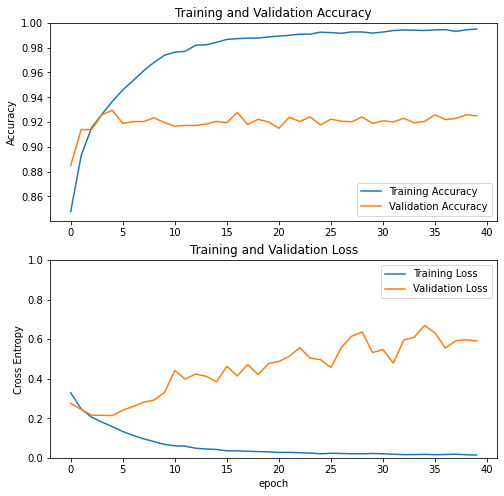

In [12]:
acc, val_acc, loss, val_loss = train_model(get_model_A(0.0, False, 0.0), TRAINING_EPOCHS)
show_plot(acc, val_acc, loss, val_loss)

Training with Data Augmentation

Training model, epochs:  40
Epoch 1/40
1200/1200 [==============================] - 32s 26ms/step - loss: 0.3231 - accuracy: 0.8490 - val_loss: 0.2877 - val_accuracy: 0.8411
Epoch 2/40
1200/1200 [==============================] - 31s 26ms/step - loss: 0.2470 - accuracy: 0.8933 - val_loss: 0.2339 - val_accuracy: 0.9120
Epoch 3/40
1200/1200 [==============================] - 31s 26ms/step - loss: 0.2208 - accuracy: 0.9079 - val_loss: 0.2244 - val_accuracy: 0.9023
Epoch 4/40
1200/1200 [==============================] - 30s 25ms/step - loss: 0.2082 - accuracy: 0.9143 - val_loss: 0.2139 - val_accuracy: 0.9203
Epoch 5/40
1200/1200 [==============================] - 31s 26ms/step - loss: 0.1985 - accuracy: 0.9196 - val_loss: 0.2114 - val_accuracy: 0.9088
Epoch 6/40
1200/1200 [==============================] - 31s 26ms/step - loss: 0.1918 - accuracy: 0.9223 - val_loss: 0.2111 - val_accuracy: 0.9296
Epoch 7/40
1200/1200 [==============================] - 31s 26ms/step - loss: 0.1846 - accuracy:

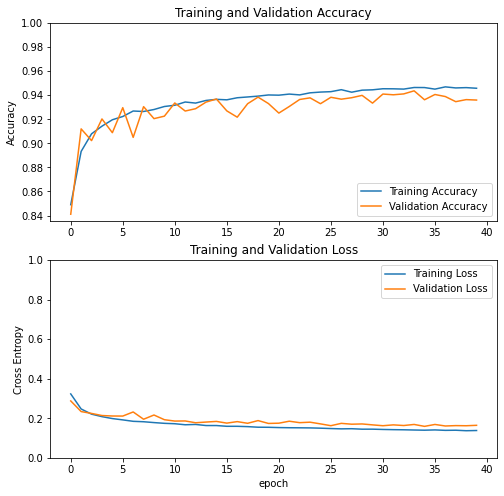

In [13]:
acc, val_acc, loss, val_loss = train_model(get_model_A(0.0, True, 0.0), TRAINING_EPOCHS)
show_plot(acc, val_acc, loss, val_loss)

# MobileNetV2 Model From Scratch

In [14]:
def get_mobile_net(drop_value=0.0, data_aug=False, l2_reg=0.0):
    inputs = tf.keras.Input(shape=(160, 160, 3))
    
    if data_aug:
        dag = data_augmentation(inputs)
        processed_input =  tf.keras.applications.mobilenet_v2.preprocess_input(dag)
    else:
        processed_input =  tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)
    
    x = base_model(processed_input)
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    x = global_average_layer(x)
    
    if drop_value > 0:
        x = keras.layers.Dropout(drop_value)(x)
    
    if l2_reg > 0:
        x = keras.layers.Dense(1, kernel_regularizer=regularizers.l2(l2_reg),
                bias_regularizer=regularizers.l2(l2_reg),
                activity_regularizer=regularizers.l2(l2_reg))(x)
    else:
        x = keras.layers.Dense(1)(x)
    return keras.Model(inputs, x)

Training model, epochs:  40
Epoch 1/40
1200/1200 [==============================] - 188s 153ms/step - loss: 0.3491 - accuracy: 0.8395 - val_loss: 1.7700 - val_accuracy: 0.4639
Epoch 2/40
1200/1200 [==============================] - 182s 152ms/step - loss: 0.2458 - accuracy: 0.8931 - val_loss: 1.8233 - val_accuracy: 0.4639
Epoch 3/40
1200/1200 [==============================] - 182s 151ms/step - loss: 0.2105 - accuracy: 0.9129 - val_loss: 2.2863 - val_accuracy: 0.4639
Epoch 4/40
1200/1200 [==============================] - 182s 151ms/step - loss: 0.1953 - accuracy: 0.9203 - val_loss: 4.4936 - val_accuracy: 0.4639
Epoch 5/40
1200/1200 [==============================] - 182s 152ms/step - loss: 0.1770 - accuracy: 0.9294 - val_loss: 0.2690 - val_accuracy: 0.8944
Epoch 6/40
1200/1200 [==============================] - 183s 153ms/step - loss: 0.1620 - accuracy: 0.9361 - val_loss: 1.6014 - val_accuracy: 0.6437
Epoch 7/40
1200/1200 [==============================] - 183s 153ms/step - loss: 0.14

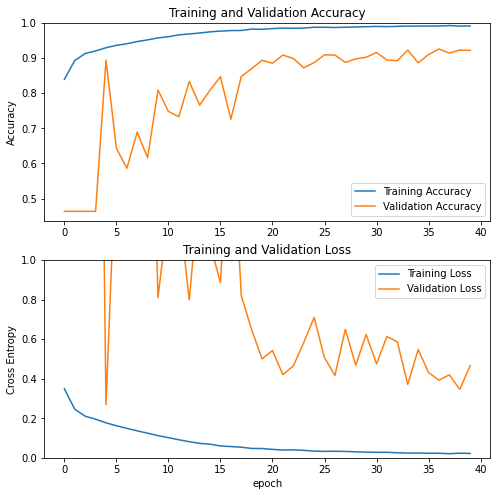

In [15]:
acc, val_acc, loss, val_loss = train_model(get_mobile_net(0.0, False, 0.0), TRAINING_EPOCHS)
show_plot(acc, val_acc, loss, val_loss)

In [ ]:
acc, val_acc, loss, val_loss = train_model(get_mobile_net(0.0, True, 0.0), TRAINING_EPOCHS)
show_plot(acc, val_acc, loss, val_loss)

Training model, epochs:  40
Epoch 1/40
1200/1200 [==============================] - 190s 155ms/step - loss: 0.3442 - accuracy: 0.8419 - val_loss: 1.2455 - val_accuracy: 0.4639
Epoch 2/40
1200/1200 [==============================] - 185s 154ms/step - loss: 0.2554 - accuracy: 0.8891 - val_loss: 1.4934 - val_accuracy: 0.4639
Epoch 3/40
1200/1200 [==============================] - 186s 155ms/step - loss: 0.2334 - accuracy: 0.9013 - val_loss: 2.4333 - val_accuracy: 0.4639
Epoch 4/40
1200/1200 [==============================] - 185s 154ms/step - loss: 0.2174 - accuracy: 0.9103 - val_loss: 4.3658 - val_accuracy: 0.4639
Epoch 5/40
1200/1200 [==============================] - 186s 155ms/step - loss: 0.2073 - accuracy: 0.9158 - val_loss: 0.2469 - val_accuracy: 0.9265
Epoch 6/40
1200/1200 [==============================] - 185s 155ms/step - loss: 0.1975 - accuracy: 0.9206 - val_loss: 2.0572 - val_accuracy: 0.6123
Epoch 7/40
1200/1200 [==============================] - 186s 155ms/step - loss: 0.19

# MobileNetV2 Model Transfer Learning/Fine Tuning

In [ ]:
TRAINING_EPOCHS = 15
base_learning_rate = 0.0001
initial_epochs = TRAINING_EPOCHS

In [ ]:
def do_transfer_learning(drop_value=0.0, data_aug=False, l2_reg=0.0):
    dense_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

    dense_base_model.trainable = False

    dense_preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    dense_global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense_prediction_layer = tf.keras.layers.Dense(1)

    dense_inputs = tf.keras.Input(shape=(160, 160, 3))
    if data_aug:
        dag = data_augmentation(dense_inputs)
        dense_x =  tf.keras.applications.mobilenet_v2.preprocess_input(dag)
    else:
        dense_x =  tf.keras.applications.mobilenet_v2.preprocess_input(dense_inputs)
    dense_x = dense_base_model(dense_x, training=False)
    dense_x = dense_global_average_layer(dense_x)
    if drop_value > 0:
        dense_x = keras.layers.Dropout(drop_value)(dense_x)
    dense_outputs = dense_prediction_layer(dense_x)
    dense_model = tf.keras.Model(dense_inputs, dense_outputs)
    
    dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    dense_history = dense_model.fit(train_dataset,
                    epochs=TRAINING_EPOCHS,
                    validation_data=validation_dataset)
    
    acc = dense_history.history['accuracy']
    val_acc = dense_history.history['val_accuracy']

    loss = dense_history.history['loss']
    val_loss = dense_history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    
    dense_base_model.trainable = True
    
    dense_fine_tune_at = 100
    
    for layer in dense_base_model.layers[:dense_fine_tune_at]:
        layer.trainable =  False
        
    dense_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
    
    total_epochs =  TRAINING_EPOCHS + TRAINING_EPOCHS

    dense_history_fine = dense_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=dense_history.epoch[-1],
                         validation_data=validation_dataset)
    
    acc += dense_history_fine.history['accuracy']
    val_acc += dense_history_fine.history['val_accuracy']

    loss += dense_history_fine.history['loss']
    val_loss += dense_history_fine.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.8, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
def train_model_transfer_learning(model, initial_epochs, fine_tune_epochs, fine_tune_at):
    print("Training model, epochs: ", initial_epochs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    
    mobile_base_model.trainable = True
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[:fine_tune_at]:
        layer.trainable =  False
        
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
    
    total_epochs =  initial_epochs + fine_tune_epochs

    print("Fine tuning, epochs: ", fine_tune_epochs)
    history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
    
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']
    
    loss, accuracy = model.evaluate(test_dataset)
    print('Test accuracy :', accuracy)
    
    return acc, val_acc, loss, val_loss

In [ ]:
def get_mobile_net(drop_value=0.0, data_aug=False, l2_reg=0.0):
    inputs = tf.keras.Input(shape=(160, 160, 3))
    
    if data_aug:
        dag = data_augmentation(inputs)
        processed_input =  tf.keras.applications.mobilenet_v2.preprocess_input(dag)
    else:
        processed_input =  tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    
    x = mobile_base_model(processed_input, training=False)
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    x = global_average_layer(x)
    
    if drop_value > 0:
        x = keras.layers.Dropout(drop_value)(x)
    
    if l2_reg > 0:
        x = keras.layers.Dense(1, kernel_regularizer=regularizers.l2(l2_reg),
                bias_regularizer=regularizers.l2(l2_reg),
                activity_regularizer=regularizers.l2(l2_reg))(x)
    else:
        x = keras.layers.Dense(1)(x)
    return keras.Model(inputs, x)

In [ ]:
do_transfer_learning(0.0, False, 0.0)

In [ ]:
do_transfer_learning(0.0, True, 0.0)

In [ ]:
do_transfer_learning(0.2, True, 0.0)

# DenseNet model

In [ ]:
def do_transfer_learning(drop_value=0.0, data_aug=False, l2_reg=0.0):
    dense_base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

    dense_base_model.trainable = False

    dense_preprocess_input = tf.keras.applications.densenet.preprocess_input
    dense_global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense_prediction_layer = tf.keras.layers.Dense(1)

    dense_inputs = tf.keras.Input(shape=(160, 160, 3))
    if data_aug:
        dag = data_augmentation(dense_inputs)
        dense_x =  tf.keras.applications.densenet.preprocess_input(dag)
    else:
        dense_x =  tf.keras.applications.densenet.preprocess_input(dense_inputs)
    dense_x = dense_base_model(dense_x, training=False)
    dense_x = dense_global_average_layer(dense_x)
    if drop_value > 0:
        dense_x = keras.layers.Dropout(drop_value)(dense_x)
    dense_outputs = dense_prediction_layer(dense_x)
    dense_model = tf.keras.Model(dense_inputs, dense_outputs)
    
    dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    dense_history = dense_model.fit(train_dataset,
                    epochs=TRAINING_EPOCHS,
                    validation_data=validation_dataset)
    
    acc = dense_history.history['accuracy']
    val_acc = dense_history.history['val_accuracy']

    loss = dense_history.history['loss']
    val_loss = dense_history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    
    dense_base_model.trainable = True
    
    dense_fine_tune_at = 660
    
    for layer in dense_base_model.layers[:dense_fine_tune_at]:
        layer.trainable =  False
        
    dense_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
    
    total_epochs =  TRAINING_EPOCHS + TRAINING_EPOCHS

    dense_history_fine = dense_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=dense_history.epoch[-1],
                         validation_data=validation_dataset)
    
    acc += dense_history_fine.history['accuracy']
    val_acc += dense_history_fine.history['val_accuracy']

    loss += dense_history_fine.history['loss']
    val_loss += dense_history_fine.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.8, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
do_transfer_learning(0.0, False, 0.0)

In [ ]:
do_transfer_learning(0.0, True, 0.0)

In [ ]:
do_transfer_learning(0.2, True, 0.0)